In [1]:
%reload_ext autoreload
%autoreload 2

# 0.03: Baseline Attack Evaluation

We can plot the effectiveness of a baseline attack that just computes the alpha quantile for the training data, and uses that as the cutoff for determining membership.

In [2]:
from quantile_diffusion_mia.config import DATASET_CONFIG

dataset = "CIFAR10"
config = DATASET_CONFIG[dataset]

2024-11-21 20:16:08.041 | INFO     | quantile_diffusion_mia.config:<module>:11 - PROJ_ROOT path is: /work3/nkale/ml-projects/quantile-diffusion-mia


First, we load the training data and compute the quantile.

In [3]:
import torch
import numpy as np
from quantile_diffusion_mia.dataset import QuantileRegressionDataset
from quantile_diffusion_mia.config import DATASET_CONFIG, MODEL_CONFIG

dataset_name = "CIFAR10"
config = DATASET_CONFIG[dataset_name]

# Load the train indices
split_path = "../" + config['quantile_regression_split_path']
output = np.load(split_path)
quantile_train_indices = output['quantile_train_indices']

# Load the dataset
data_path = "../" + config['quantile_regression_data_path']
train_dataset = QuantileRegressionDataset.load(data_path)
train_dataset.set_indices(quantile_train_indices)

In [4]:
train_t_errors = train_dataset.t_errors[train_dataset.indices]
alpha = 0.01
alpha_quantile = np.quantile(train_t_errors.cpu().numpy(), alpha)

Next, we load the evaluation data and compute the pseudomodel's predictions.

In [5]:
# Load the eval indices
split_path = "../" + config['quantile_regression_split_path']
output = np.load(split_path)
quantile_eval_indices = output['quantile_eval_indices']

# Load the dataset
data_path = "../" + config['quantile_regression_data_path']
eval_dataset = QuantileRegressionDataset.load(data_path)
eval_dataset.set_indices(quantile_eval_indices)

In [6]:
from torch.utils.data import DataLoader
import pandas as pd

eval_t_errors = eval_dataset.t_errors[eval_dataset.indices].cpu().numpy()
predictions = eval_t_errors < alpha_quantile
predictions = ["Member" if p else "Nonmember" for p in predictions]

results_df = pd.DataFrame()
results_df["Baseline Prediction"] = predictions
results_df["Label"] = np.array(eval_dataset.labels, dtype=str)[eval_dataset.indices]

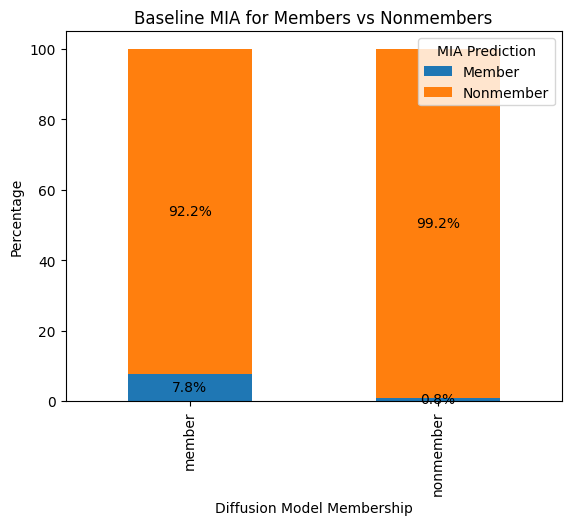

In [7]:
import matplotlib.pyplot as plt

# Calculate vote counts
vote_counts = results_df.groupby(['Label', 'Baseline Prediction']).size().unstack(fill_value=0)

# Normalize the vote counts to percentages
vote_counts_percentage = vote_counts.div(vote_counts.sum(axis=1), axis=0) * 100

# Plot the data
ax = vote_counts_percentage.plot(kind='bar', stacked=True)
plt.title(f'Baseline MIA for Members vs Nonmembers')
plt.xlabel('Diffusion Model Membership')
plt.ylabel('Percentage')
plt.legend(title='MIA Prediction')

# Add numerical labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()